In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Power\ Grid\ Optimization

/content/drive/MyDrive/Power Grid Optimization


In [3]:
!pip install torch
!pip install torch-geometric
!pip install pandas openpyxl
!pip install pandapower
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/Power%20Grid%20Optimization
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for powergrid_torch (pyproject.toml) ... done
  Created wheel for powergrid_torch: filename=powergrid_torch-1.0.0-0.editable-py3-none-any.whl size=1466 sha256=dbe390c52a0e8599b2d3e45ede8b3aed2894fe23023f70f1f80a997c1b5ca8b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-8w4a_s8a/wheels/59/7e/dc/e7c694b3435d46bfb0bc9c3b277d4f33fd0c87b4e5e0a16cb4
Successfully built powergrid_torch


In [5]:
import powergrid_torch

In [6]:
%cd /content/drive/MyDrive/Power\ Grid\ Optimization/powergrid_torch/data/14Bus/

/content/drive/MyDrive/Power Grid Optimization/powergrid_torch/data/14Bus


In [7]:
import numpy as np
import pandas as pd
import torch
from powergrid_torch.utils import pre_processing
import os
from powergrid_torch.models.gnn import GNNModel
from powergrid_torch.models.transformer import GraphTransformerModel
from powergrid_torch.training import train
from powergrid_torch.utils.extras import summary
import time

In [8]:
path_data = os.getcwd() # os.path.join(os.getcwd(), r'../data/14Bus/')
train_df = pd.read_excel(os.path.join(path_data, 'PF_Dataset_1.xlsx')).values
val_df = pd.read_excel(os.path.join(path_data, 'PF_Dataset_2.xlsx')).values

In [9]:
stats_result = pre_processing.stats(train_df, val_df, 1., 1., 14)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

for idx, val in enumerate(stats_result):
    val = val.to(device=device)
    stats_result[idx] = val

y_norm_train = stats_result[1]
y_train_mean = stats_result[3]
y_train_std = stats_result[5]

y_norm_val = stats_result[7]
y_val_mean = stats_result[9]
y_val_std = stats_result[11]

train_loader, val_loader = pre_processing.main(train_df, val_df, 1., 1., 14)

--------------------Data preparation completed successfully--------------------


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
device = pre_processing.get_default_device()
print(device)

cuda


In [11]:

def model_run(gnn_type = 'GCN', n_epochs = 5, lambda_l2 = 1e-6, n_bus = 14):

    if (gnn_type != 'GraphTransformer'):
        model = pre_processing.to_device(GNNModel(in_channels=5, hidden_channels=8, out_channels=2, n_bus=14, gnn_type=gnn_type, is_batch_norm='False', is_dropout=0), device)

    elif (gnn_type == 'GraphTransformer'):
        model = pre_processing.to_device(GraphTransformerModel(in_channels=5, hidden_channels=8, out_channels=2, n_transformer_layers=2, n_heads=3, concat_heads=True), device)


    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=lambda_l2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

    summary(model)
    history = train.fit(n_epochs, 0.001, model, train_loader, val_loader, optimizer, scheduler, y_train_mean, y_train_std, y_val_mean, y_val_std, n_bus)
    return history


In [12]:
train_loader = pre_processing.DeviceDataLoader(train_loader, device)
val_loader = pre_processing.DeviceDataLoader(val_loader, device)

In [14]:
start = time.time()
history_transformer = model_run("GraphTransformer", n_epochs=400)
end = time.time()
print(f"Time Taken = {round(end-start, 2)}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Model Summary ---
GraphTransformerModel(
  (transformer_layers): ModuleList(
    (0): TransformerConv(5, 8, heads=3)
    (1): TransformerConv(24, 8, heads=3)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (final_projection): Linear(in_features=24, out_features=2, bias=True)
)


--- Detailed Parameter Summary ---
transformer_layers.0.lin_key.weight                [24, 5]              120
transformer_layers.0.lin_key.bias                  [24]                 24
transformer_layers.0.lin_query.weight              [24, 5]              120
transformer_layers.0.lin_query.bias                [24]                 24
transformer_layers.0.lin_value.weight              [24, 5]              120
transformer_layers.0.lin_value.bias                [24]                 24
transformer_layers.0.lin_skip.weight               [24, 5]              120
transformer_layers.0.lin_skip.bias                 [24]                 24
transformer_layers.1.lin_key.weight                [24, 24]

In [15]:
start = time.time()
history_GraphConv = model_run(gnn_type='GraphConv', n_epochs = 400)
end = time.time()
print(f"Time Taken = {round(end-start, 2)}")

--- Model Summary ---
GNNModel(
  (conv1): GraphConv(5, 8)
  (conv2): GraphConv(8, 8)
  (conv_out): GraphConv(8, 2)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (linear): Linear(in_features=112, out_features=28, bias=True)
)


--- Detailed Parameter Summary ---
conv1.lin_rel.weight                               [8, 5]               40
conv1.lin_rel.bias                                 [8]                  8
conv1.lin_root.weight                              [8, 5]               40
conv2.lin_rel.weight                               [8, 8]               64
conv2.lin_rel.bias                                 [8]                  8
conv2.lin_root.weight                              [8, 8]               64
conv_out.lin_rel.weight                            [2, 8]               16
conv_out.lin_rel.bias                         

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch[0], train_loss: 0.96274, val_loss: 0.96639
Epoch[1], train_loss: 0.89874, val_loss: 0.91871
Epoch[2], train_loss: 0.86223, val_loss: 0.88536
Epoch[3], train_loss: 0.83362, val_loss: 0.85515
Epoch[4], train_loss: 0.80602, val_loss: 0.82415
Epoch[5], train_loss: 0.7772, val_loss: 0.79121
Epoch[6], train_loss: 0.74659, val_loss: 0.75625
Epoch[7], train_loss: 0.71438, val_loss: 0.71991
Epoch[8], train_loss: 0.68117, val_loss: 0.68288
Epoch[9], train_loss: 0.6476, val_loss: 0.6459
Epoch[10], train_loss: 0.61432, val_loss: 0.60972
Epoch[11], train_loss: 0.58202, val_loss: 0.57502
Epoch[12], train_loss: 0.55118, val_loss: 0.54228
Epoch[13], train_loss: 0.52216, val_loss: 0.51178
Epoch[14], train_loss: 0.49509, val_loss: 0.48365
Epoch[15], train_loss: 0.47001, val_loss: 0.45784
Epoch[16], train_loss: 0.44683, val_loss: 0.43411
Epoch[17], train_loss: 0.42528, val_loss: 0.41222
Epoch[18], train_loss: 0.40512, val_loss: 0.39194
Epoch[19], train_loss: 0.38619, val_loss: 0.37306
Epoch[20], tr

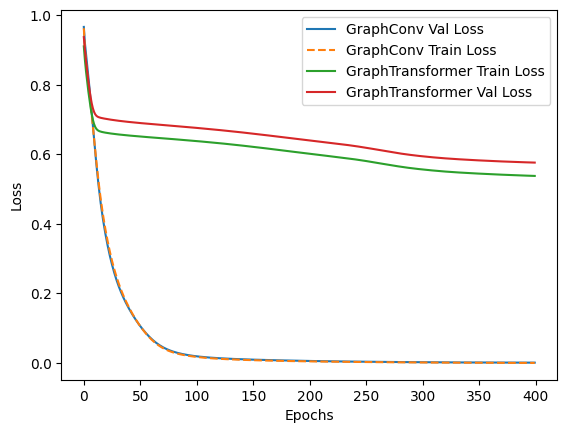

In [26]:
import matplotlib.pyplot as plt
iterations = np.arange(0, 400)
train_loss_gc = [item['train_loss'] for item in history_GraphConv]
val_loss_gc = [item['val_loss'] for item in history_GraphConv]
plt.plot(iterations, val_loss_gc, label='GraphConv Val Loss')
plt.plot(iterations, train_loss_gc, '--', label='GraphConv Train Loss')

train_loss_gt = [item['train_loss'] for item in history_transformer]
val_loss_gt = [item['val_loss'] for item in history_transformer]
plt.plot(iterations, train_loss_gt, label='GraphTransformer Train Loss')
plt.plot(iterations, val_loss_gt , label='GraphTransformer Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()